In [3]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable 
from torch.utils.data.sampler import SubsetRandomSampler


import matplotlib as mpl
from matplotlib import pyplot as plt
from collections import namedtuple

from tqdm import tqdm
%matplotlib inline

import seaborn as sns
sns.set()

In [4]:
!pip install --editable .

Obtaining file:///home/jupyter/neuron-hidden-inference
  Preparing metadata (setup.py) ... done
  Attempting uninstall: helper-functions
    Found existing installation: helper-functions 0.1.2
    Uninstalling helper-functions-0.1.2:
      Successfully uninstalled helper-functions-0.1.2
  Running setup.py develop for helper-functions


In [5]:
from helper_functions import get_default_device, to_device
from helper_functions import evaluate_model, r2_loss

In [6]:
device = get_default_device()
print(f'device: {device} \ndevice name: {torch.cuda.get_device_name()}')

device: cuda 
device name: Tesla V100-SXM2-16GB


In [21]:
# Set random seeds for numpy and torch
np.random.seed(42)
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
class neuron_unit_encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(10,1).to(device)
    self.act1 = nn.Sigmoid()

  def forward(self,x):
    x = self.linear1(x)
    x = self.act1(x)
    return x

In [9]:
model_e = neuron_unit_encoder()

Two ways:

1. Think about the rank of the activity directly - generate a certain number of independent processes and then mix them together in generating the spike trains (give them weights basically). And then sample each of those from a poisson

Ex: if there are 10 inputs, and we want everything to be rank 10. We generate the ip, if they are completely uncorrelated, then each synapse gets one of the underlying modes and then we poisson sample them.
If they are correlated, then each of them have the same weight 
Vary the weights onto the modes and the number of underlying modes seperately 

EXPLICIT: 

Need a number which describes how "EVEN" are the weights across the modes. Something like the entropy 
If the weights are perfectly even -> everything is very correlated

- Generate the sources 
- A mixing matrix [num of synapes * num of input modes]
    - Rows of the matrix would be characterized by the entropy
    - Normalize the matrix 

Source modes (gaussian), each synapse gets some weight onto the source mode 
Last step is to poisson sample 

To evaulate this, calculate the correlation matrices 
    - not necessarily the poisson values, but the weights that go into the poisson 
    
 
2. Find ways to sample trains from a correlation matrix (hard) 


# Generating correlated inputs


In [10]:
# Globals
NUM_SYNAPSES = 10 
DATASET_SIZE = 1000
VAL_RATIO = 0.2
BATCH_SIZE = 256
NUM_FEATURES = 10 
loss_fn = nn.MSELoss()

## Generating source modes

In [9]:
# Generate the source modes as gaussian (num_synapses times)

source_modes_list = []

for i in range(0,NUM_SYNAPSES):
    s_i = torch.normal(0, 1, size=(1,DATASET_SIZE)).to(device)
    source_modes_list.append(s_i)

In [10]:
source_modes_list[1].shape

torch.Size([1, 1000])

In [11]:
print(torch.normal(0, 1, size=(1,10)))

tensor([[-0.1776, -0.5011, -2.0210,  0.5212,  1.6987, -1.5135, -0.1887,  0.5263,
         -0.4353, -0.7563]])


# Exploring Negative correlation 

- Momentum in the optimizer , could confuse it. Exclude the parameter from momentum.
- use a different optimizer

In [44]:
class neuron_unit_decoder_w_hidden_init_fix(nn.Module): 
  '''
    - Has the same variance as the input features 
    - Has the weights forn the hidden acitvity as 1, to remove the
    redundancy 
  '''
  def __init__(self,train_size):
    super().__init__()
    self.linear1 = nn.Linear(10,1) 
    self.act1 = nn.Sigmoid()
    self.h_activity_vec = torch.nn.Parameter(torch.normal(0,1, size=(train_size,1))) 
    
    # Initialize the weights  of the hidden  vector by 1
    # Equal  to  make the weihgt of the the linear layer's last col to be 1 
    # nn.init.constant_(self.h_activity_vec.weight.data, 1)
    nn.init.constant_(self.linear1.weight[0,-1].data, 1)
    # nn.init.constant_(self.linear1.bias.data, 1)
    
  def forward(self,x):    
    # Truncate the last column of x, since that's the index
    # Note: only one example of the training data gets passed on during the forward pass
    #       so the number of rows here are 1, not 1000 

    input_wo_time = x[:,:-1].to(device) # Exclude the timepoint column [1,9]
    timepoint = x[:,-1].to(device) # [1]
    
    input_to_network = torch.cat((input_wo_time, self.h_activity_vec[timepoint.long()-1]), dim = 1).to(device) # [1,10]

    x = input_to_network
    x = self.linear1(x)
    x = self.act1(x)
    return x

In [45]:
def train_decoder_w_hidden_w_var_penalty(model, opti, datagen, loss_fn, var_coeff, n_epochs=50, learning_rate=1e-4 ):

  params = model.parameters()

  if opti == 'adam':
    optimizer = torch.optim.Adam(params, lr=learning_rate)
  elif opti == 'adadelta':
    optimizer = torch.optim.Adadelta(params, lr = learning_rate) 
  elif opti == 'adagrad':
    optimizer = torch.optim.Adagrad(params, lr = learning_rate)
  elif opti == 'adamw':
    optimizer = torch.optim.AdamW(params, lr = learning_rate)
  
  model_training_params = dict()
  model_training_params['loss_vals'] = []
  model_training_params['l2_loss_vals'] = []
  model_training_params['validation_loss'] = []
  model_training_params['n_epochs'] = n_epochs
  model_training_params['corr_vals'] = []
  gt_var = torch.var(datagen.original)

  for i in tqdm(range(n_epochs)):
    epoch_loss= []
    epoch_l2_loss = [] 
    epoch_val_loss = []
    
    for xb,yb in datagen.train_dl_hidden:
      out = model(xb).to(device)
      yb = yb.to(device)
      loss = loss_fn(out, yb)
    
      # norm = torch.linalg.vector_norm(model.h_activity_vec,ord = l_norm)
        
      hidden_var = torch.var(model.h_activity_vec)
      var_diff  = (hidden_var-  gt_var)**2
      var_loss = torch.maximum(var_diff,torch.tensor(0))
      l2_loss = var_loss 
               
      loss = loss + var_loss*var_coeff # The coefficient is large, can go to inf
      
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()
      epoch_loss.append(loss.item())
      epoch_l2_loss.append(l2_loss.item())
    
    
    with torch.no_grad():
        model.eval()
        for xb, yb in datagen.test_dl_hidden:
            pred = model(xb).to(device)
            yb = yb.to(device)
            val_loss = loss_fn(pred,yb)
            epoch_val_loss.append(val_loss.item())
            

    corr = r2_loss(model.h_activity_vec, datagen.original)
    model_training_params['corr_vals'].append(corr)
 
    model_training_params['loss_vals'].append(sum(epoch_loss)/len(epoch_loss))
    model_training_params['l2_loss_vals'].append(sum(epoch_l2_loss)/len(epoch_l2_loss))
    model_training_params['validation_loss'].append(sum(epoch_val_loss)/len(epoch_val_loss))
    
    
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | train loss: {loss.item():}')

  return model_training_params

In [12]:
def generate_dataset_poisson(dataset_size, rate_type, rate = 1,val_ratio = VAL_RATIO, batch_size = BATCH_SIZE, num_features = NUM_FEATURES, add_GWN  = False ):
    '''
    Generate the dataset containing dataset_size number of samples with num_features features.
    The samples have a mean of 0 and a std of 1
    
    Args:
        dataset_size: Size of the dataset (split into 80% training, 20% validation)
        num_features: number of synapeses for the model neuron
        add_GWN: Flag to add Gaussian white noise to the data
    
    Returns: 
    PyTorch dataloaders train_dataloader and test_dataloader 
    '''
    # Example: 
    # Total datset size = 1250 samples
    # Training set of 1000 samples, test set of 250 samples
    
    # x = torch.normal(0, 1, size=(dataset_size,num_features)).to(device) # Mean = 0, std = 1
    if rate_type == 'variable':
        rates = torch.rand(dataset_size, num_features)* rate # Rates between [0,1) 
    elif rate_type == 'constant':
        rates = torch.ones(dataset_size, num_features)* rate
    x = torch.poisson(rates).to(device)
    
    if add_GWN:
        noise = gen_GWN(dataset_size, num_features).to(device)
        x = x + noise
    
    train_size = int((1-val_ratio)*dataset_size)
    val_size = int(val_ratio*dataset_size)

    inputs = x[:train_size]
    inputs_val = x[train_size:]
    
    original =  inputs[:,-1].reshape(train_size,1)

    # print(f'Train input with shape {inputs.shape} = \n{inputs} \n\nTest input with shape {inputs_val.shape} = \n{inputs_val}')
    
    # Generate outputs using the encoder model
    with torch.no_grad():
      output = model_e(inputs)
      output_val = model_e(inputs_val)
    
    # print(f'Output shape: {output.shape}\nOutput val shape: {output_val.shape}')
    
    timepoints = torch.arange(start = 1, end = inputs.shape[0]+1).to(device) 
    timepoints = torch.reshape(timepoints,(inputs.shape[0],1))
    # print(f'timepoints shape: {timepoints.shape}')

    # Do the same operations for the validation set
    timepoints_val = torch.arange(start = 1, end = inputs_val.shape[0]+1).to(device) 
    timepoints_val = torch.reshape(timepoints_val, (inputs_val.shape[0],1))
    # print(f'timepoints_val shape: {timepoints_val.shape}')

    input_w_time = torch.cat((inputs, timepoints), dim = 1)
    # print(input_w_time[0]) 

    input_w_time_val = torch.cat((inputs_val, timepoints_val), dim = 1)
    # print(input_w_time_val[0])

    # Create the input with missing 10th neuron values
    inputs = inputs.to(device)
    inputs_val = inputs_val.to(device)

    input_w_hidden = inputs[:,:9].clone() # [1000,9]   # Change '9' for future features (not 10)
    input_w_hidden_val = inputs_val[:,:9].clone()

    # print(input_w_hidden)
    input_w_time_hidden = torch.cat((input_w_hidden, timepoints), dim = 1).to(device) # [1000,10]
    # print(input_w_time_hidden)
    input_w_time_hidden_val = torch.cat((input_w_hidden_val, timepoints_val), dim = 1).to(device)
    
    # This gets passed on to the decoder network as the input (x)

    # Creating the dataloader
    # train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    test_ds_hidden_params = TensorDataset(input_w_time_hidden_val, output_val)


    # batch_size = 256
    train_dl_hidden = DataLoader(train_ds_hidden_params, batch_size, shuffle = True)
    train_dl_hidden.device = device

    test_dl_hidden = DataLoader(test_ds_hidden_params, batch_size , shuffle = True)
    test_dl_hidden.device = device 


    next(iter(train_dl_hidden))
    next(iter(test_dl_hidden))
    
    return inputs, output, original, input_w_time_hidden, train_dl_hidden, test_dl_hidden

In [13]:
def init_datagen_poisson(dataset_size, rate_type, rate, val_ratio = VAL_RATIO):
    
    datagen = namedtuple('datagen',["inputs","output", "original","input_w_time_hidden", "train_dl_hidden", "test_dl_hidden", "train_size", "val_size"])
    datagen.train_size = int((1-val_ratio)*dataset_size)
    datagen.val_size = int(val_ratio*dataset_size)
    datagen.inputs, datagen.output, datagen.original, datagen.input_w_time_hidden, datagen.train_dl_hidden, datagen.test_dl_hidden= generate_dataset_poisson(dataset_size, rate_type, rate)
    return datagen

In [14]:
def run_dataset_sweep_poisson(dataset_size_list, rate_type, rate = 1, n_epochs = 20000, var = 1):
    for dataset_size in dataset_size_list:
        
        print(f'Training on {dataset_size} samples... \n\n')
        datagen = init_datagen_poisson(dataset_size, rate_type, rate)
        model_iter = neuron_unit_decoder_w_hidden_val_fixed(datagen.train_size, var).to(device)
        model_training_params = train_decoder_var_penalty_val_fix(model_iter, datagen, loss_fn, var_coeff = 1, n_epochs = n_epochs)
        
        evaluate_model(model = model_iter,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )
    return

In [31]:
dataset_size = 1250
datagen = init_datagen_poisson(dataset_size, 'variable' , 1)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

Dataset size: 1250

Training size: 1000
Validation size: 250


In [35]:
decoder_1000_adam =  neuron_unit_decoder_w_hidden_init_fix(datagen.train_size).to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(decoder_1000_adam, 'adam', datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4009/20000 [00:52<03:37, 73.56it/s]

iteration 4000/20000 | train loss: 0.0010614083148539066


 40%|████      | 8015/20000 [01:45<02:33, 78.09it/s]

iteration 8000/20000 | train loss: 0.000619780330453068


 60%|██████    | 12009/20000 [02:41<02:22, 56.25it/s]

iteration 12000/20000 | train loss: 0.00010681974526960403


 80%|████████  | 16001/20000 [03:36<01:18, 50.94it/s]

iteration 16000/20000 | train loss: 6.55286430628621e-06


100%|██████████| 20000/20000 [04:31<00:00, 73.66it/s]

iteration 20000/20000 | train loss: 1.702602947517562e-09


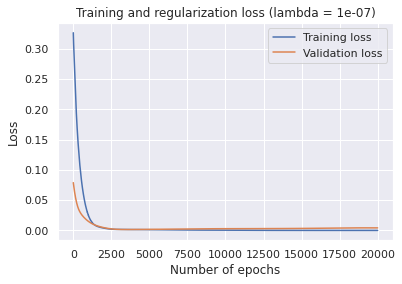

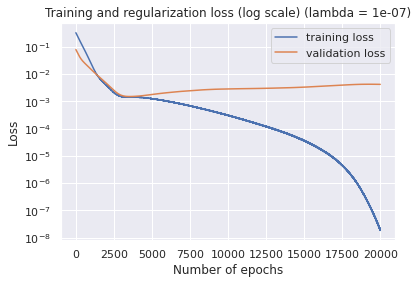

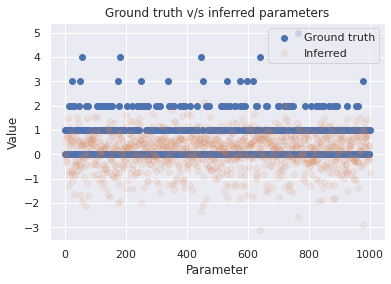

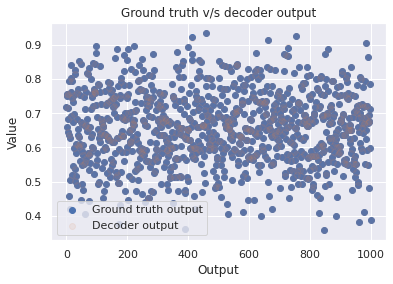

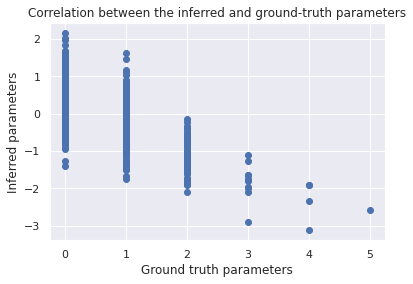

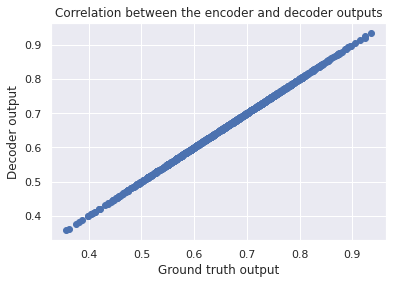

In [37]:
evaluate_model(model = decoder_1000_adam,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

In [38]:
decoder_1000_adadelta =  neuron_unit_decoder_w_hidden_init_fix(datagen.train_size).to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(decoder_1000_adadelta, 'adadelta', datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4009/20000 [00:54<04:27, 59.82it/s]

iteration 4000/20000 | train loss: 0.29603880643844604


 40%|████      | 8012/20000 [01:47<02:32, 78.51it/s]

iteration 8000/20000 | train loss: 0.2718120217323303


 60%|██████    | 12013/20000 [02:41<01:43, 77.21it/s]

iteration 12000/20000 | train loss: 0.2597106099128723


 80%|████████  | 16010/20000 [03:35<00:51, 77.27it/s]

iteration 16000/20000 | train loss: 0.25019267201423645


100%|██████████| 20000/20000 [04:29<00:00, 74.21it/s]

iteration 20000/20000 | train loss: 0.24009011685848236


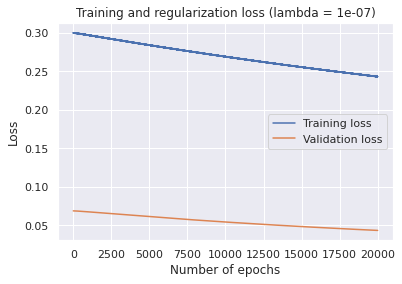

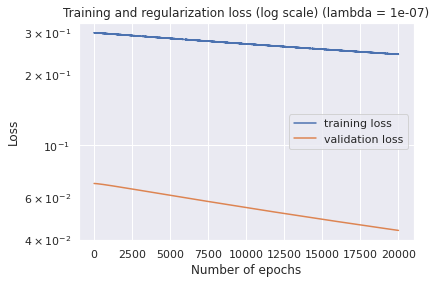

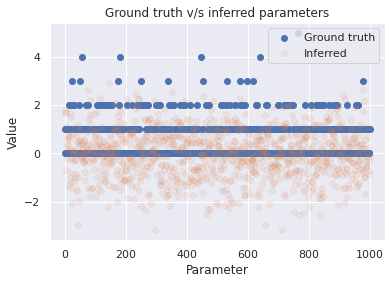

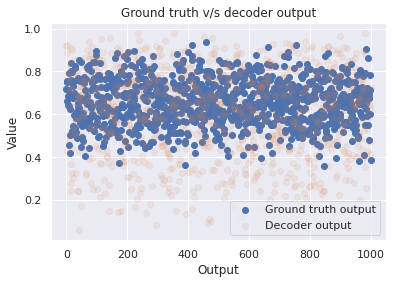

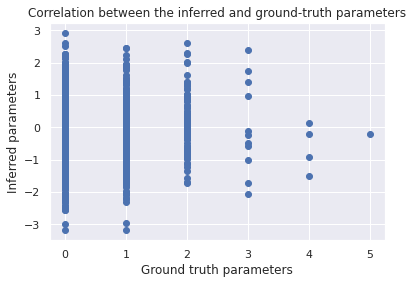

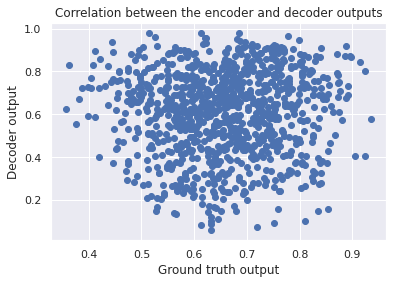

In [39]:
evaluate_model(model = decoder_1000_adadelta,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

In [42]:
decoder_1000_adagrad =  neuron_unit_decoder_w_hidden_init_fix(datagen.train_size).to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(decoder_1000_adagrad, 'adagrad', datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4013/20000 [00:53<03:25, 77.95it/s]

iteration 4000/20000 | train loss: 0.2949717938899994


 40%|████      | 8008/20000 [01:46<02:32, 78.43it/s]

iteration 8000/20000 | train loss: 0.2707092761993408


 60%|██████    | 12010/20000 [02:39<01:44, 76.50it/s]

iteration 12000/20000 | train loss: 0.25782644748687744


 80%|████████  | 16008/20000 [03:32<00:52, 76.10it/s]

iteration 16000/20000 | train loss: 0.24674251675605774


100%|██████████| 20000/20000 [04:24<00:00, 75.47it/s]


iteration 20000/20000 | train loss: 0.2401268035173416


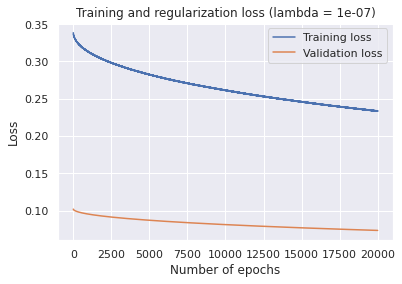

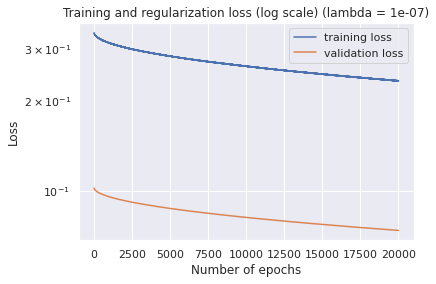

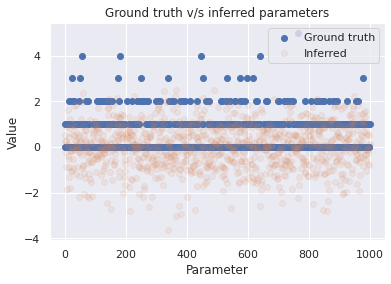

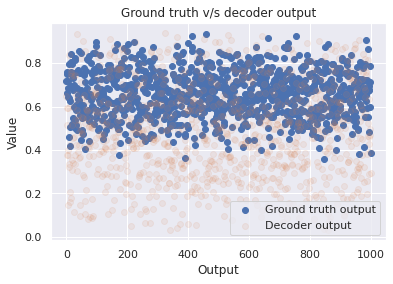

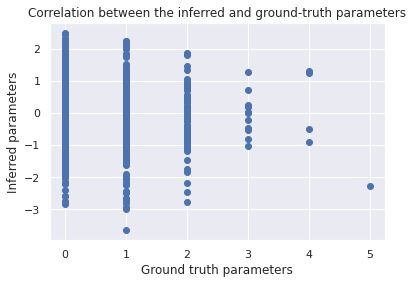

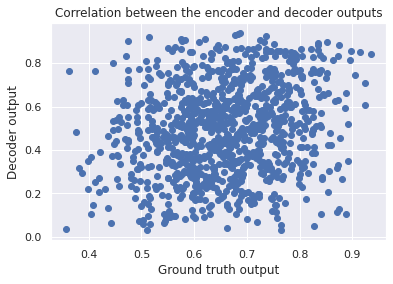

In [43]:
evaluate_model(model = decoder_1000_adagrad,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

In [44]:
decoder_1000_adamw =  neuron_unit_decoder_w_hidden_init_fix(datagen.train_size).to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(decoder_1000_adamw, 'adamw', datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4015/20000 [00:53<03:24, 78.07it/s]

iteration 4000/20000 | train loss: 0.0013655723305419087


 40%|████      | 8013/20000 [01:46<02:32, 78.47it/s]

iteration 8000/20000 | train loss: 0.0004212897038087249


 60%|██████    | 12015/20000 [02:39<01:40, 79.81it/s]

iteration 12000/20000 | train loss: 9.256350313080475e-05


 80%|████████  | 16011/20000 [03:31<00:49, 80.01it/s]

iteration 16000/20000 | train loss: 3.6947296848666156e-06


100%|██████████| 20000/20000 [04:24<00:00, 75.75it/s]

iteration 20000/20000 | train loss: 3.0738820776948783e-12


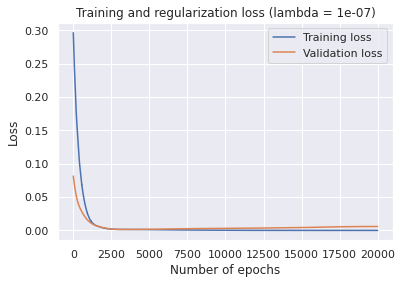

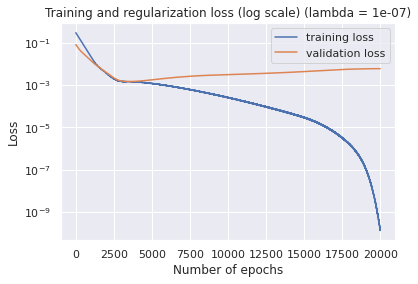

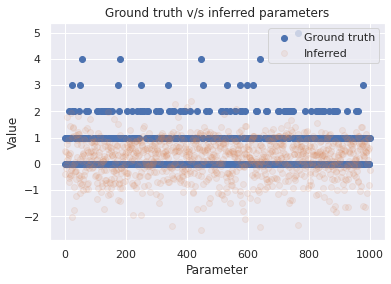

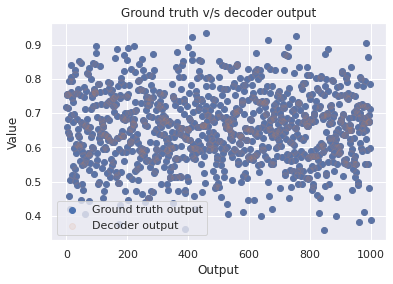

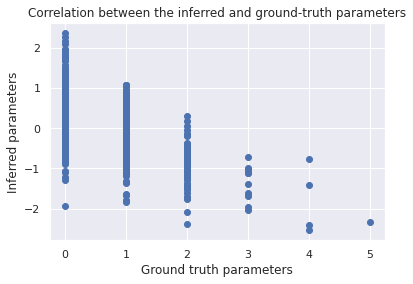

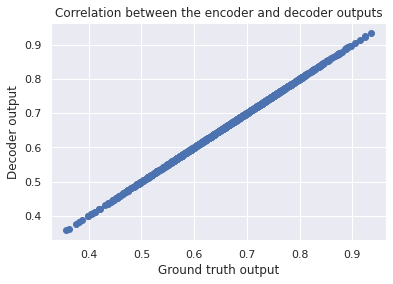

In [45]:
evaluate_model(model = decoder_1000_adamw,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

# Generating correlated spike trains (various methods) 


In [12]:
import time

In [13]:
# @title Plotting Functions

def example_plot_myCC():
  pars = default_pars(T=50000, dt=.1)

  c = np.arange(10) * 0.1
  r12 = np.zeros(10)
  for i in range(10):
    I1gL, I2gL = correlate_input(pars, mu=20.0, sig=7.5, c=c[i])
    r12[i] = my_CC(I1gL, I2gL)

  plt.figure()
  plt.plot(c, r12, 'bo', alpha=0.7, label='Simulation', zorder=2)
  plt.plot([-0.05, 0.95], [-0.05, 0.95], 'k--', label='y=x',
           dashes=(2, 2), zorder=1)
  plt.xlabel('True CC')
  plt.ylabel('Sample CC')
  plt.legend(loc='best')



# the function plot the raster of the Poisson spike train
def my_raster_Poisson(range_t, spike_train, n):
  """
  Generates poisson trains

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster plot of the spike train
  """

  # find the number of all the spike trains
  N = spike_train.shape[0]

  # n should smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # plot rater
  i = 0
  while i < n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)', fontsize=12)
  plt.ylabel('Neuron ID', fontsize=12)

def plot_c_r_LIF(c, r, mycolor, mylabel):
  z = np.polyfit(c, r, deg=1)
  c_range = np.array([c.min() - 0.05, c.max() + 0.05])
  plt.plot(c, r, 'o', color=mycolor, alpha=0.7, label=mylabel, zorder=2)
  plt.plot(c_range, z[0] * c_range + z[1], color=mycolor, zorder=1)

In [14]:
# @title Helper Functions
def default_pars(**kwargs):
  pars = {}

  ### typical neuron parameters###
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['V_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  ### simulation parameters ###
  pars['T'] = 400. # Total duration of simulation [ms]
  pars['dt'] = .1  # Simulation time step [ms]

  ### external parameters if any ###
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized
                                                         # time points [ms]
  return pars


def run_LIF(pars, Iinj):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value or an array

  Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, V_L = pars['V_init'], pars['V_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  tr = 0.

  # simulate the LIF dynamics
  rec_spikes = []   # record spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # calculate the increment of the membrane potential
    dv = (-(v[it] - V_L) + Iinj[it] / g_L) * (dt / tau_m)

    # update the membrane potential
    v[it + 1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


def my_GWN(pars, sig, myseed=False):
  """
  Function that calculates Gaussian white noise inputs

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed. You can fix the seed of the random number generator so
  # that the results are reliable however, when you want to generate multiple
  # realization make sure that you change the seed for each new realization
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_GWN = sig * np.random.randn(Lt) * np.sqrt(pars['tau_m'] / dt)

  return I_GWN


def LIF_output_cc(pars, mu, sig, c, bin_size, n_trials=20):
  """ Simulates two LIF neurons with correlated input and computes output correlation

  Args:
  pars       : parameter dictionary
  mu         : noise baseline (mean)
  sig        : noise amplitute (standard deviation)
  c          : correlation coefficient ~[0, 1]
  bin_size   : bin size used for time series
  n_trials   : total simulation trials

  Returns:
  r          : output corr. coe.
  sp_rate    : spike rate
  sp1        : spike times of neuron 1 in the last trial
  sp2        : spike times of neuron 2 in the last trial
  """

  r12 = np.zeros(n_trials)
  sp_rate = np.zeros(n_trials)
  for i_trial in range(n_trials):
    I1gL, I2gL = correlate_input(pars, mu, sig, c)
    _, sp1 = run_LIF(pars, pars['g_L'] * I1gL)
    _, sp2 = run_LIF(pars, pars['g_L'] * I2gL)

    my_bin = np.arange(0, pars['T'], bin_size)

    sp1_count, _ = np.histogram(sp1, bins=my_bin)
    sp2_count, _ = np.histogram(sp2, bins=my_bin)

    r12[i_trial] = my_CC(sp1_count[::20], sp2_count[::20])
    sp_rate[i_trial] = len(sp1) / pars['T'] * 1000.

  return r12.mean(), sp_rate.mean(), sp1, sp2

In [27]:
def my_CC(i, j):
  """
  Args:
    i, j  : two time series with the same length

  Returns:
    rij   : correlation coefficient
  """

  # Calculate the covariance of i and j
  cov = ((i - i.mean()) * (j - j.mean())).sum()

  # Calculate the variance of i
  var_i = ((i - i.mean()) * (i - i.mean())).sum()

  # Calculate the variance of j
  var_j = ((j - j.mean()) * (j - j.mean())).sum()

  # Calculate the correlation coefficient
  rij = cov / np.sqrt(var_i*var_j)

  return rij

In [30]:
def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

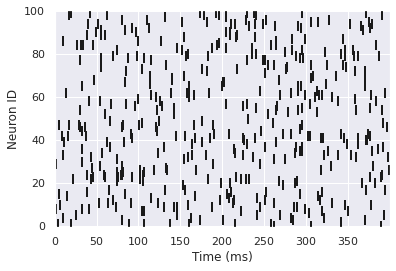

In [38]:
pars = default_pars()
pre_spike_train = Poisson_generator(pars, rate=10, n=100, myseed=2020)
my_raster_Poisson(pars['range_t'], pre_spike_train, 100)

In [40]:
pre_spike_train.shape

(100, 4000)

In [25]:
def generate_corr_Poisson(pars, poi_rate, c, myseed=False):
  """
  function to generate correlated Poisson type spike trains
  Args:
    pars       : parameter dictionary
    poi_rate   : rate of the Poisson train
    c.         : correlation coefficient ~[0, 1]

  Returns:
    sp1, sp2   : two correlated spike time trains with corr. coe. c
  """

  range_t = pars['range_t']

  mother_rate = poi_rate / c
  mother_spike_train = Poisson_generator(pars, rate=mother_rate,
                                         n=1, myseed=myseed)[0]
  sp_mother = range_t[mother_spike_train > 0]

  L_sp_mother = len(sp_mother)
  sp_mother_id = np.arange(L_sp_mother)
  L_sp_corr = int(L_sp_mother * c)

  np.random.shuffle(sp_mother_id)
  sp1 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  np.random.shuffle(sp_mother_id)
  sp2 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  return sp1, sp2

In [28]:
def corr_coeff_pairs(pars, rate, c, trials, bins):
  """
  Calculate the correlation coefficient of two spike trains, for different
  realizations

  Args:
      pars   : parameter dictionary
      rate   : rate of poisson inputs
      c      : correlation coefficient ~ [0, 1]
      trials  : number of realizations
      bins   : vector with bins for time discretization

  Returns:
    r12      : correlation coefficient of a pair of inputs
  """

  r12 = np.zeros(n_trials)

  for i in range(n_trials):
    # Generate correlated Poisson inputs
    sp1, sp2 = generate_corr_Poisson(pars, poi_rate, c, myseed=2020+i)

    # Bin the spike times of the first input
    sp1_count, _ = np.histogram(sp1, bins=bins)

    # Bin the spike times of the second input
    sp2_count, _ = np.histogram(sp2, bins=bins)

    # Calculate the correlation coefficient
    r12[i] = my_CC(sp1_count, sp2_count)

  return r12


poi_rate = 20.
c = 0.2  # set true correlation
pars = default_pars(T=10000)
# bin the spike time
bin_size = 20  # [ms]
my_bin = np.arange(0, pars['T'], bin_size)
n_trials = 100  # 100 realizations

r12 = corr_coeff_pairs(pars, rate=poi_rate, c=c, trials=n_trials, bins=my_bin)
print(f'True corr coe = {c:.3f}')
print(f'Simu corr coe = {r12.mean():.3f}')

True corr coe = 0.200
Simu corr coe = 0.197


# Generating correlated inputs (Paper, cox method) 

In [1]:
class correlated_spikes(object):
    """ correlated_spikes Is the main class implemented [1]. Two basic methods
        are implemented in this script: Cox processes and the Mixture method.
    """

    def __init__(self, C, rates, n_proc):
        """ Constructor of correlated_spikes class.
            Args:
                C (mxm array)   : Is the correlation matrix (positive definite)
                                  Its diagonal contains the firing rates for
                                  the spike trains
                rates (m array) : Firing rates for spike trains (only for
                                  Mixture method)
                n_proc          : Number of processes (dimensions of C matrix)
            Returns:
        """
        self.n_proc = n_proc
        self.C = C
        self.r = rates
        self.spikes = 0

    def rectify_and_decomp_corr(self):
        """ rectify_and_decomp_corr - It rectifies and decomposes matrix C
            using Cholesky's decomposition.
            Args:
            Returns:
                L (mxm array)  : Lower triangular matrix (after Cholesky's
                                 decomposition) with diagona filled with r^2 *
                                 alpha (see [1])
        """
        # Change diagonal with r^2
        d = np.diag(self.C)**2
        np.fill_diagonal(self.C, d)

        # Cholesky decomposition
        L = np.linalg.cholesky(self.C)

        # Compute eigenvalues of L
        w, v = np.linalg.eig(L)

        # Compute alpha as the minimum eigenvalue with negative sign
        alpha = -w.real.min()

        # Fill the diagonal of L with r^2 * alpha
        np.fill_diagonal(L, d * alpha)

        return L

    def cox_process(self, tau_c=10, time=100, dt=1):
        """ Cox process (doubly stochastic process). It generates n_proc
            number of correlated spike trains based on C matrix.
            Args:
                tau_c (float)   : Time constant (lambda, see [1])
                time (int)      : Duration of spike trains (ms)
                dt (float)      : Time step (discretization)
        """
        ticks = int(time / dt)      # Simulation ticks

        Lambda = np.exp(-dt / tau_c)
        Sigma = np.sqrt(1 - np.exp(-2 * dt / tau_c))

        # Set up rates vector
        R = np.diag(self.C)
        Y = np.random.normal(0, 1, (self.n_proc,))
        S = np.zeros((ticks, self.n_proc))

        # Rectify C
        L = self.rectify_and_decomp_corr()

        for t in range(ticks):
            # Compute N independent Ornstein-Uhlberg processes
            Y = Y * Lambda + np.random.normal(0, Sigma, (self.n_proc,))

            # Compute instantaneous rates
            X = R + np.dot(L, Y)

            # Create spikes list
            prob = np.random.uniform(0, 1, (self.n_proc,))
            idx = (X * 0.001 * dt) > prob
            S[t, idx] = 1

        self.spikes = S.copy()
        return S

    def random_latency(self, size):
        """ random_latency - Returns a random number based on the exponential
            distribution.
            Args:
                size (int)  : Size of random numbers sample
            Returns:
        """
        return np.random.exponential(1, size=size)

    def optimization_mixture(self, nu, P):
        """ optimization_mixture - This function computes the best mixture
            matrix P and the corresponding vector nu (firing rates) by applying
            a gradient descent.
            Args:
                P (mx2n)  : Mixture matrix
                nu (2n)   : Firing rates of independent spike trains (sources)
            Returns:
        """
        n = self.n_proc
        P_ = P[:, :n].copy()
        nu_ = nu[:n].copy()
        A = np.zeros((n, n))

        # Initialization of nu and P
        nu_ = self.r.copy()
        np.fill_diagonal(P_, 1)

        # Steps
        b = 0.01 / n
        a = (1. / n) * b

        # Iterations
        U = np.zeros((n, ))
        for ns in range(20000):
            for i in range(n):
                for j in range(n):
                    if i != j:
                        x = 0.0
                        for k in range(n):
                            x += P_[i, k] * P_[j, k] * nu_[k]
                        A[i, j] = x - self.C[i, j]
                    else:
                        A[i, j] = 0

            tmp = np.dot(nu_.T, P_)
            U[tmp >= self.r] = 1
            U[tmp < self.r] = 0

            tmp = np.dot(A, P_)
            tmp_y = np.dot(tmp, nu_)
            tmp_u = np.dot(U, nu_)

            Y = P_ - 4 * a * tmp_y - b * tmp_u

            Y[Y < 0] = 0
            Y[Y > 1] = 1
            P_ = Y

            for i in range(n):
                X = 0
                for k in range(n):
                    for l in range(n):
                        X += P_[k, i] * P_[l, i] * A[k, l]

                Y = np.dot(U, P_)
                nu_[i] -= a * X + b * Y[i]
                nu_[nu_ < 0] = 0

        X = np.dot(P_, nu_)
        nu[:n] = nu_.copy()
        nu[n:] = (self.r - X)

        P[:, :n] = P_
        P[:, n:] = np.zeros((n, n))
        np.fill_diagonal(P[:, n:], 1)

        if any(nu[nu < 0]):
            raise ValueError("nu contains illegal values!")

        if any(P[P < 0]) or any(P[P > 1]):
            raise ValueError("P contains illegal values!")

    def offline_mixture(self, P, nu, n_src=1, n_trg=1, tau_c=10, time=1000):
        """ offline_mixture - It's the Mixture methods implemented in [1].
            It returns a spike list containing correlated spike trains.
            Args:
                P (mx2n array) : Mixture matrix (mixture probability)
                nu (2x array)  : Firing rates of independent spike trains
                                 (sources)
                n_src (int)    : Number of sources spike trains
                n_trg (int)    : Number of targets (correlated) spike trains
                tau_c (float)  : Time constant
                time           : Duration of correlated spike trains
            Returns:
                spks (array)   : Numpy structured array containing events time
                                 and ids (id is the number of target spike
                                 train)
        """
        # Average target rate
        r_mean = np.mean(np.dot(P, nu))

        # Optimal window size
        w_size = n_src * 1.0 / r_mean

        # Window
        w_size = int(time * 0.001)

        # Number of spikes in trains
        num_sources = np.random.poisson(nu * w_size).astype('int')

        # Generate Poisson spike trains
        source_train = []
        for i in range(num_sources.shape[0]):
            source_train.append(np.random.uniform(
                0, w_size, num_sources[i]) * 1000)

        spk, tm = [], []
        for i in range(n_src):
            for j in range(n_trg):
                num_targets = np.random.binomial(num_sources[i], P[j, i])
                target_train = np.random.choice(source_train[i],
                                                size=num_targets,
                                                replace=False)
                spk.extend(np.ones((num_targets,)) * j)
                tm.extend(target_train +
                          self.random_latency(num_targets) * tau_c)
        spk = np.array(spk, dtype='int')
        tm = np.array(tm)

        spks = np.recarray(spk.shape[0], dtype=[('t', float), ('id', int)])
        spks['t'] = tm
        spks['id'] = spk
        spks.sort()
        return spks

    def extract_pyNCS_list(self, id_init=0):
        """ extract_pyNCS_list - Extracts a spike list compatible with pyNCS
            package.
            Args:
                id_init (int) : Initial id for spike trains
            Returns:
                tmp (array)   : A spike list that is compatible to pyNCS AER.
        """
        time, id_end = self.spikes.shape
        id_end += id_init
        ids = range(id_init, id_end)
        tmp = []
        for t in range(time):
            for i, j in enumerate(ids):
                if self.spikes[t, i] != 0:
                    tmp.append((j, t))
        return np.array(tmp, dtype='int')

    def raster_plot(self):
        """ raster_plot - Draws the raster plot of already generated spike
            trains.
            Args:
            Returns:
        """
        self.spikes[self.spikes == 0] = np.nan

        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i in range(self.n_proc):
            ax.plot(self.spikes[:, i] + i, '|k', ms=20, mew=1)
        ax.set_ylim([-.5, self.n_proc + 1])
        ax.set_yticks([])

In [ ]:
# Cox proces method 

'''
C (mxm array)   : Is the correlation matrix (positive definite)
                                  Its diagonal contains the firing rates for
                                  the spike trains
                rates (m array) : Firing rates for spike trains (only for
                                  Mixture method)
                n_proc          : Number of processes (dimensions of C matrix)

  tau_c (float)   : Time constant (lambda, see [1])
                time (int)      : Duration of spike trains (ms)
                dt (float)      : Time step (discretization)
'''

n_proc = 5

C = (np.ones((n_proc, n_proc)) +
     np.random.uniform(0, 1, (n_proc, n_proc)) * 5.0)

np.fill_diagonal(C, [5, 6, 7, 8, 9])

C = np.maximum(C, C.T)
# C = np.ones((n_proc, n_proc))
rates = np.array([5, 15, 4, 6, 7])

cor_spk = correlated_spikes(C, rates, n_proc)
spikes = cor_spk.cox_process(time=20000)
cor_spk.raster_plot()
spk = cor_spk.extract_pyNCS_list()
plt.show()

In [36]:
sp_tensor = torch.from_numpy(spikes)
sp_tensor

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=torch.float64)

In [32]:
def gen_cox_process_corr(n_proc = 10, time = 10000):
    n_proc = n_proc

    C = (np.ones((n_proc, n_proc)) +
         np.random.uniform(0, 1, (n_proc, n_proc)) * 5.0)

    np.fill_diagonal(C, [5, 6, 7, 8, 9])

    C = np.maximum(C, C.T)
    # C = np.ones((n_proc, n_proc))
    rates = np.array([5, 15, 4, 6, 7])

    cor_spk = correlated_spikes(C, rates, n_proc)
    spikes = cor_spk.cox_process(time=time)
    cor_spk.raster_plot()
    spk = cor_spk.extract_pyNCS_list()
    
    print(spikes.shape)
    plt.show()
    
    return spikes


(10000, 10)


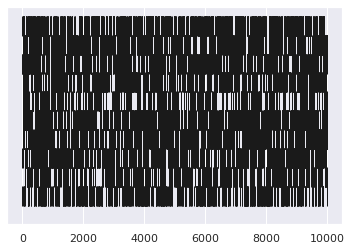

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [33]:
gen_cox_process_corr()

In [55]:
def generate_dataset_poisson_correlated(dataset_size,val_ratio = VAL_RATIO, batch_size = BATCH_SIZE, num_features = NUM_FEATURES):
    '''
    
    '''
    # Example: 
    # Total datset size = 1250 samples
    # Training set of 1000 samples, test set of 250 samples
    
    # x = torch.normal(0, 1, size=(dataset_size,num_features)).to(device) # Mean = 0, std = 1

    #     if rate_type == 'variable':
#         rates = torch.rand(dataset_size, num_features)* rate # Rates between [0,1) 
#     elif rate_type == 'constant':
#         rates = torch.ones(dataset_size, num_features)* rate
    
#     x = torch.poisson(rates).to(device)
    
    
    x = torch.from_numpy(gen_cox_process_corr(n_proc = 10, time = dataset_size)).to(device).float()
     
    
    train_size = int((1-val_ratio)*dataset_size)
    val_size = int(val_ratio*dataset_size)

    inputs = x[:train_size]
    inputs_val = x[train_size:]
    
    original =  inputs[:,-1].reshape(train_size,1)

    # print(f'Train input with shape {inputs.shape} = \n{inputs} \n\nTest input with shape {inputs_val.shape} = \n{inputs_val}')
    
    # Generate outputs using the encoder model
    with torch.no_grad():
      output = model_e(inputs)
      output_val = model_e(inputs_val)
    
    # print(f'Output shape: {output.shape}\nOutput val shape: {output_val.shape}')
    
    timepoints = torch.arange(start = 1, end = inputs.shape[0]+1).to(device) 
    timepoints = torch.reshape(timepoints,(inputs.shape[0],1))
    # print(f'timepoints shape: {timepoints.shape}')

    # Do the same operations for the validation set
    timepoints_val = torch.arange(start = 1, end = inputs_val.shape[0]+1).to(device) 
    timepoints_val = torch.reshape(timepoints_val, (inputs_val.shape[0],1))
    # print(f'timepoints_val shape: {timepoints_val.shape}')

    input_w_time = torch.cat((inputs, timepoints), dim = 1)
    # print(input_w_time[0]) 

    input_w_time_val = torch.cat((inputs_val, timepoints_val), dim = 1)
    # print(input_w_time_val[0])

    # Create the input with missing 10th neuron values
    inputs = inputs.to(device)
    inputs_val = inputs_val.to(device)

    input_w_hidden = inputs[:,:9].clone() # [1000,9]   # Change '9' for future features (not 10)
    input_w_hidden_val = inputs_val[:,:9].clone()

    # print(input_w_hidden)
    input_w_time_hidden = torch.cat((input_w_hidden, timepoints), dim = 1).to(device) # [1000,10]
    # print(input_w_time_hidden)
    input_w_time_hidden_val = torch.cat((input_w_hidden_val, timepoints_val), dim = 1).to(device)
    
    # This gets passed on to the decoder network as the input (x)

    # Creating the dataloader
    # train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)s
    test_ds_hidden_params = TensorDataset(input_w_time_hidden_val, output_val)


    # batch_size = 256
    train_dl_hidden = DataLoader(train_ds_hidden_params, batch_size, shuffle = True)
    train_dl_hidden.device = device

    test_dl_hidden = DataLoader(test_ds_hidden_params, batch_size , shuffle = True)
    test_dl_hidden.device = device 


    next(iter(train_dl_hidden))
    next(iter(test_dl_hidden))
    
    return inputs, output, original, input_w_time_hidden, train_dl_hidden, test_dl_hidden

In [56]:
def init_datagen_poisson_corr(dataset_size, val_ratio = VAL_RATIO):
    
    datagen = namedtuple('datagen',["inputs","output", "original","input_w_time_hidden", "train_dl_hidden", "test_dl_hidden", "train_size", "val_size"])
    datagen.train_size = int((1-val_ratio)*dataset_size)
    datagen.val_size = int(val_ratio*dataset_size)
    datagen.inputs, datagen.output, datagen.original, datagen.input_w_time_hidden, datagen.train_dl_hidden, datagen.test_dl_hidden= generate_dataset_poisson_correlated(dataset_size)
    return datagen

(1250, 10)


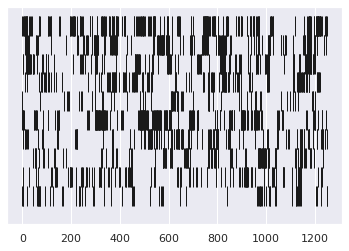

Dataset size: 1250

Training size: 1000
Validation size: 250


In [57]:
dataset_size = 1250
datagen = init_datagen_poisson_corr(dataset_size)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

In [58]:
decoder_1000 =  neuron_unit_decoder_w_hidden_init_fix(datagen.train_size).to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(decoder_1000, 'adam', datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4009/20000 [00:52<03:51, 69.20it/s]

iteration 4000/20000 | train loss: 0.0004374259733594954


 40%|████      | 8012/20000 [01:46<02:35, 77.09it/s]

iteration 8000/20000 | train loss: 6.402749568223953e-05


 60%|██████    | 12015/20000 [02:40<01:45, 76.05it/s]

iteration 12000/20000 | train loss: 6.67688482280937e-06


 80%|████████  | 16014/20000 [03:34<00:52, 75.47it/s]

iteration 16000/20000 | train loss: 5.354337511017347e-14


100%|██████████| 20000/20000 [04:28<00:00, 74.58it/s]

iteration 20000/20000 | train loss: 4.914733203742472e-11


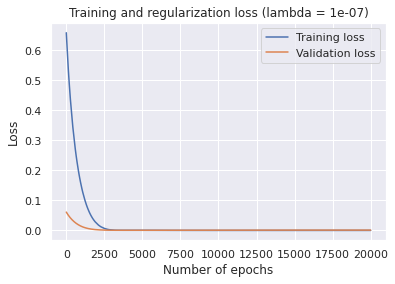

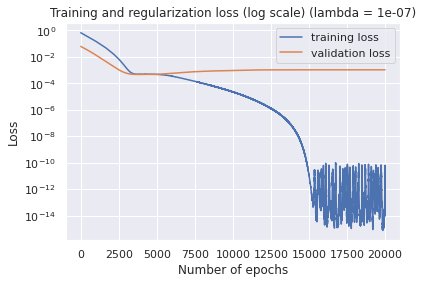

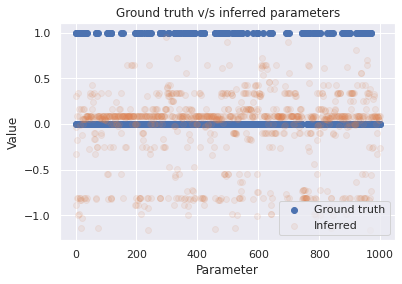

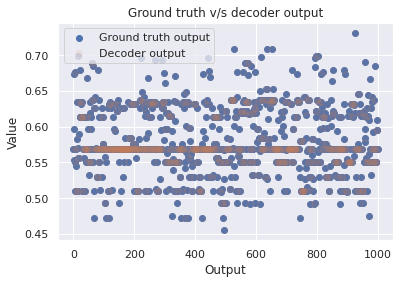

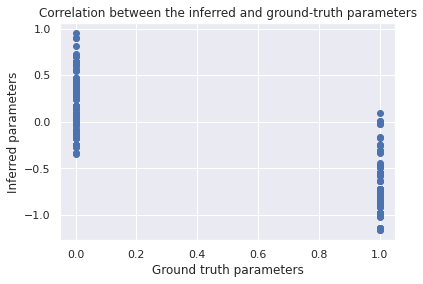

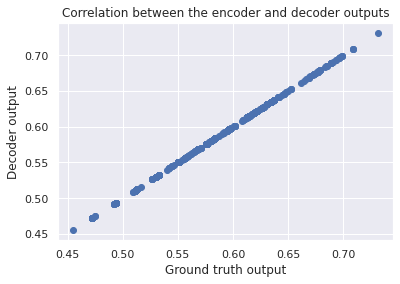

In [59]:
evaluate_model(model = decoder_1000,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

(12500, 10)


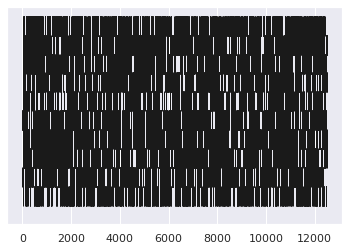

Dataset size: 12500

Training size: 10000
Validation size: 2500


In [60]:
dataset_size = 12500
datagen = init_datagen_poisson_corr(dataset_size)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

In [68]:
decoder_10k =  neuron_unit_decoder_w_hidden_init_fix(datagen.train_size).to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(decoder_10k, 'adam', datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4001/20000 [08:33<33:17,  8.01it/s]

iteration 4000/20000 | train loss: 2.67662136899105e-09


 40%|████      | 8001/20000 [17:06<24:26,  8.18it/s]

iteration 8000/20000 | train loss: 4.516165219570212e-12


 60%|██████    | 12001/20000 [25:38<21:20,  6.25it/s]

iteration 12000/20000 | train loss: 1.3353762540191383e-12


 80%|████████  | 16001/20000 [34:07<08:10,  8.16it/s]

iteration 16000/20000 | train loss: 1.2242651337146526e-11


100%|██████████| 20000/20000 [42:32<00:00,  7.84it/s]

iteration 20000/20000 | train loss: 6.519229600598919e-13


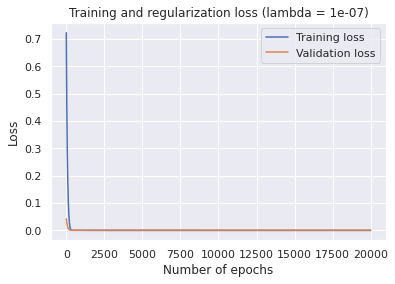

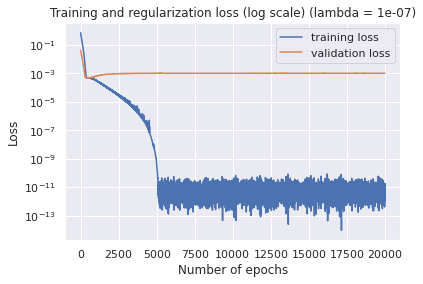

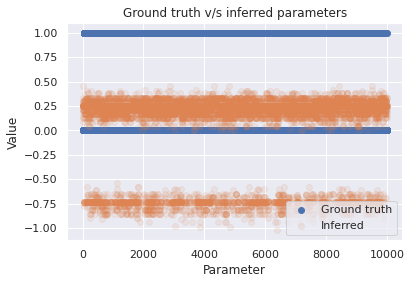

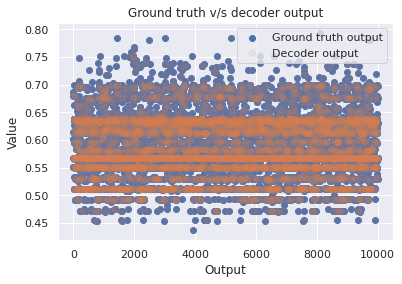

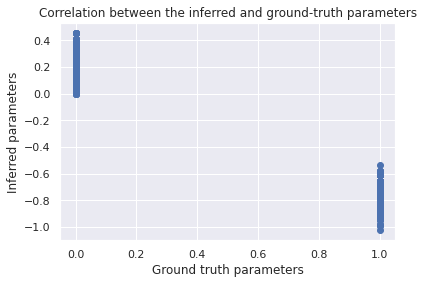

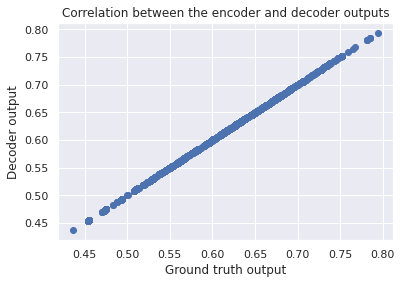

In [69]:
evaluate_model(model = decoder_10k,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

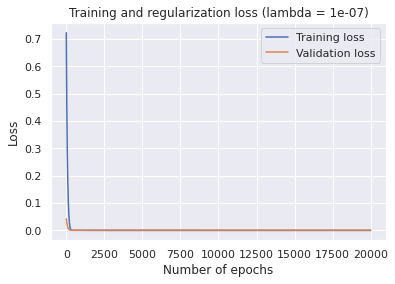

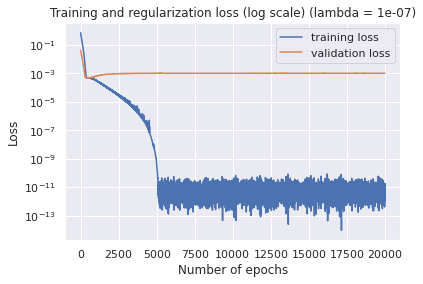

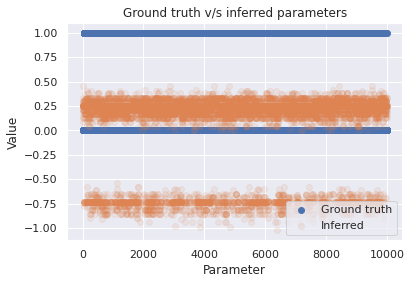

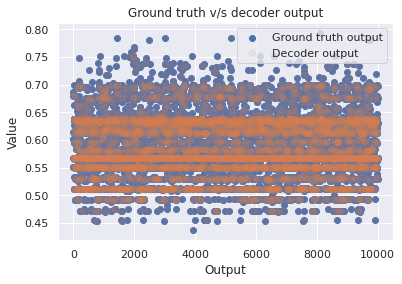

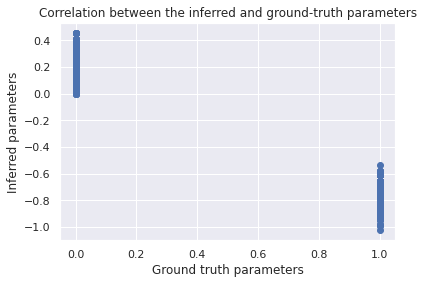

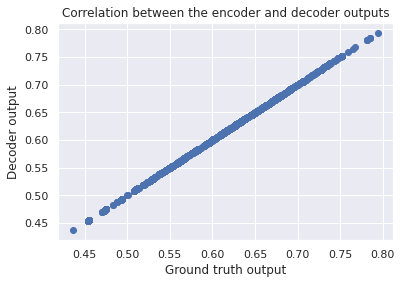

In [71]:
evaluate_model(model = decoder_10k,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

- The datapoints are Bernoulli, no longer Poisson
- Can make them Poisson by binning them in time

- For creating correlation matrices from one correlation slider number (ex 0.2 or 0.8) -> We want to maximize Entropy. Sample from all of the corr matrices that have a mean off-diagnonal value equal to this number 
- OR sample values into the correlation matrix, with a mean that's equal to the value of the slider. Variance could be proportional to the mean 

- Calculate the corr matrix for the sampled spikes and compare the Design corr matrix to the sample corr matrix

# Convert Bernoulli data to Poisson sampled 

# Create correlation matrices from a number 

In [109]:
# Create the base correlation matrix
x = np.zeros((10,10))
np.fill_diagonal(x, val = 1)

print(x, x.shape)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] (10, 10)


In [110]:
# Number of upper off-diagonal elements of an n*n matrix is (n*(n-1))/2
num_offdiag_elems = (x.shape[0] * (x.shape[0]-1)) // 2

# print(num_offdiag_elems)
corr_vals = np.random.normal(0, 1, size=(num_offdiag_elems)) # mean 0, var = 1
print(corr_vals, corr_vals.shape)


[-5.69110375e-01 -1.49948935e-01  1.03927766e+00  2.76572972e+00
  5.95336190e-01  5.59817488e-01 -2.38814346e-01 -3.33152851e-01
  6.35271859e-01  1.46889446e-01 -3.14414878e-01 -6.09961444e-01
  7.24575871e-01 -4.56689038e-02  1.03368887e+00  5.86301028e-01
  5.94356119e-03  7.66426279e-01 -3.03846928e+00 -1.07206484e+00
 -5.27117548e-01 -2.52382043e-01  2.56435597e-03  5.01298861e-01
  9.99567646e-01  6.93884782e-02 -1.71759494e+00  2.71942041e-01
  1.13846486e+00  2.96214859e-01 -2.09569562e-01  2.57436979e-03
  7.53436847e-01 -2.08074058e-01 -6.92971376e-01 -8.19074833e-01
 -9.20148157e-01  1.31094984e+00  1.73468354e+00 -4.78899067e-01
  1.14285127e+00  2.61679445e-01 -5.43540549e-01  2.07194158e-01
 -5.11510755e-01] (45,)


In [120]:
x = x.astype('float32')

x[np.triu_indices(x.shape[0],k=1)] = [corr_vals]
print(np.around(x,2)) # Just print 2 digits of precision

[[ 1.   -0.57 -0.15  1.04  2.77  0.6   0.56 -0.24 -0.33  0.64]
 [ 0.    1.    0.15 -0.31 -0.61  0.72 -0.05  1.03  0.59  0.01]
 [ 0.    0.    1.    0.77 -3.04 -1.07 -0.53 -0.25  0.    0.5 ]
 [ 0.    0.    0.    1.    1.    0.07 -1.72  0.27  1.14  0.3 ]
 [ 0.    0.    0.    0.    1.   -0.21  0.    0.75 -0.21 -0.69]
 [ 0.    0.    0.    0.    0.    1.   -0.82 -0.92  1.31  1.73]
 [ 0.    0.    0.    0.    0.    0.    1.   -0.48  1.14  0.26]
 [ 0.    0.    0.    0.    0.    0.    0.    1.   -0.54  0.21]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.   -0.51]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]


In [149]:
def create_corr_mat(corr):
    # Create the base correlation matrix
    x = np.zeros((10,10))
    np.fill_diagonal(x, val = 1)

    # print(x, x.shape)
    
    # Number of upper off-diagonal elements of an n*n matrix is (n*(n-1))/2
    num_offdiag_elems = (x.shape[0] * (x.shape[0]-1)) // 2

    # print(num_offdiag_elems)
    corr_vals = np.random.normal(corr, corr/2, size=(num_offdiag_elems)) # mean = corr,  var = 1
    # print(corr_vals, corr_vals.shape)
    
    x = x.astype('float32')

    x[np.triu_indices(x.shape[0],k=1)] = [corr_vals]
    # print(np.around(x,2)) # Just print 2 digits of precision
    
    # Copy the upper triangular matrix to the lower triangular matrix
    i_lower = np.tril_indices(x.shape[0], -1)
    x[i_lower] = x.T[i_lower]
    return x 

In [150]:
x = create_corr_mat(0.5)
print(np.around(x,2))

[[ 1.   -0.12  0.81  0.37  0.05  0.42  0.92  0.64  0.49  0.57]
 [-0.12  1.    0.28  0.61  0.76 -0.05  0.68  0.4   0.8   0.66]
 [ 0.81  0.28  1.    0.6   0.5   0.55  0.59  0.64  0.25  0.77]
 [ 0.37  0.61  0.6   1.    0.2   0.57  0.13  0.5   0.5   0.5 ]
 [ 0.05  0.76  0.5   0.2   1.    0.13  0.26  0.81  0.89  0.61]
 [ 0.42 -0.05  0.55  0.57  0.13  1.    0.57  0.27  0.31  0.27]
 [ 0.92  0.68  0.59  0.13  0.26  0.57  1.    0.64  0.82  0.47]
 [ 0.64  0.4   0.64  0.5   0.81  0.27  0.64  1.    0.91  0.53]
 [ 0.49  0.8   0.25  0.5   0.89  0.31  0.82  0.91  1.    0.3 ]
 [ 0.57  0.66  0.77  0.5   0.61  0.27  0.47  0.53  0.3   1.  ]]


## Generate spike trains with the custom correlation matrix

In [157]:
def gen_cox_process_corr_custom(n_proc = 10, time = 10000):
    
    n_proc = n_proc

    # C = (np.ones((n_proc, n_proc)) +
         # np.random.uniform(0, 1, (n_proc, n_proc)) * 5.0)

    # np.fill_diagonal(C, [5, 6, 7, 8, 9])

    # C = np.maximum(C, C.T)
    # C = np.ones((n_proc, n_proc))
    C = x
    print(C, C.shape)
    rates = np.array([5, 15, 4, 6, 7])

    cor_spk = correlated_spikes(C, rates, n_proc)
    spikes = cor_spk.cox_process(time=time)
    cor_spk.raster_plot()
    spk = cor_spk.extract_pyNCS_list()
    
    print(spikes.shape)
    plt.show()
    
    return spikes

In [158]:
gen_cox_process_corr_custom()

[[ 1.         -0.12173484  0.80777806  0.3691964   0.05261407  0.41608173
   0.9223517   0.6367624   0.49302682  0.5713422 ]
 [-0.12173484  1.          0.27628005  0.610744    0.76266074 -0.04831154
   0.6795868   0.40186033  0.7981946   0.65888864]
 [ 0.80777806  0.27628005  1.          0.5999894   0.5025211   0.55000556
   0.58630097  0.6379389   0.24862492  0.77426815]
 [ 0.3691964   0.610744    0.5999894   1.          0.2042141   0.5672851
   0.13396111  0.49777937  0.49768656  0.5021461 ]
 [ 0.05261407  0.76266074  0.5025211   0.2042141   1.          0.12572573
   0.26410097  0.8100243   0.88640237  0.60718507]
 [ 0.41608173 -0.04831154  0.55000556  0.5672851   0.12572573  1.
   0.56789553  0.26626387  0.31207782  0.2652707 ]
 [ 0.9223517   0.6795868   0.58630097  0.13396111  0.26410097  0.56789553
   1.          0.64169776  0.8160162   0.46765462]
 [ 0.6367624   0.40186033  0.6379389   0.49777937  0.8100243   0.26626387
   0.64169776  1.          0.9143262   0.53275275]
 [ 0.4930

LinAlgError: Matrix is not positive definite